# Heartbeat Audio Classification

In [2]:
# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
assert tf.__version__ == "1.7.0"
tf.logging.set_verbosity(tf.logging.INFO)

## The Data

The data is a set of heartbeat audio recordings labelled into three different categories (normal, murmur, or extrastole (i.e. extrasystole)). 

In [3]:
dataset = [{'path': path, 'label': path.split('/')[6]} 
               for path in glob.glob("/Users/marshal/Projects/heartbeat/dataset/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

,label,path,x
0,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[761, 359, 433, 360, 428, 560, 578, 829, 687, ..."
1,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[479, 452, 433, 420, 370, 391, 344, 392, 403, ..."
2,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-982, -973, -832, -813, -409, -231, -386, -23..."
3,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-195, -97, 280, 331, 141, 242, 204, 190, 94, ..."
4,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-703, -1073, -1345, -1006, -1089, -1601, -160..."


## Visualizing the data

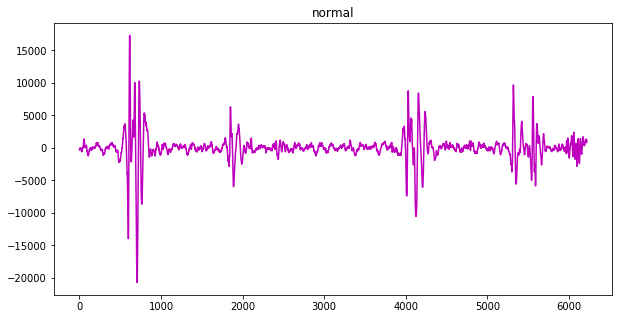

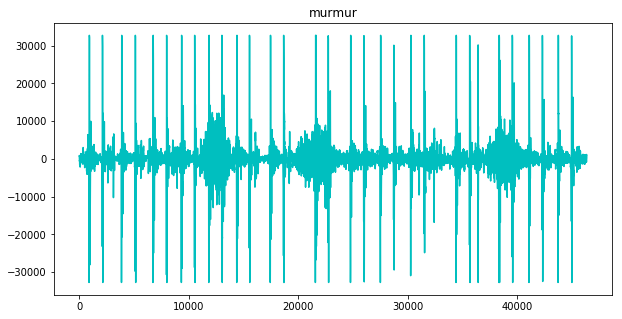

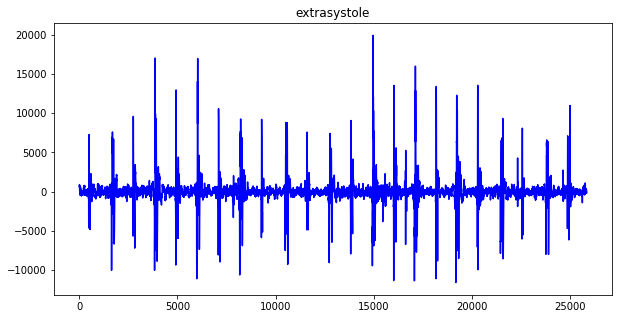

In [4]:
# Collect three samples from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')

plt.figure(2, figsize=(10, 5))
plt.title('murmur')
plt.plot(murmur['x'].values[0], c='c')

plt.figure(3, figsize=(10, 5))
plt.title('extrasystole')
plt.plot(extrasystole['x'].values[0], c='b')

## Preprocessing the Data

The audio recordings are of varying lengths. This will become a problem when we need to train a model. So, to resolve this, I repeat the data read from the wavefile until the longest file's time has been reached.

In [5]:
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

,label,path,x
0,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[761.0, 359.0, 433.0, 360.0, 428.0, 560.0, 578..."
1,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[479.0, 452.0, 433.0, 420.0, 370.0, 391.0, 344..."
2,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-982.0, -973.0, -832.0, -813.0, -409.0, -231...."
3,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-195.0, -97.0, 280.0, 331.0, 141.0, 242.0, 20..."
4,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-703.0, -1073.0, -1345.0, -1006.0, -1089.0, -..."


Now that the data is of consistent shape, let's see if we can spot the difference between the classes ourselves.

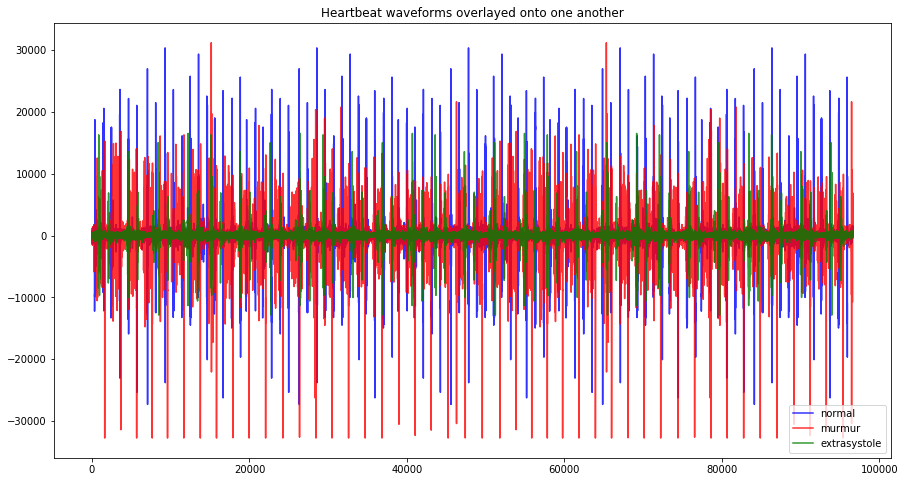

In [6]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(murmur['x'].values[0], c='r', label='murmur', alpha=0.8)
plt.plot(extrasystole['x'].values[0], c='g', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

#### The same visualization but as a spectrogram

Text(0.5,0,'Time [sec]')

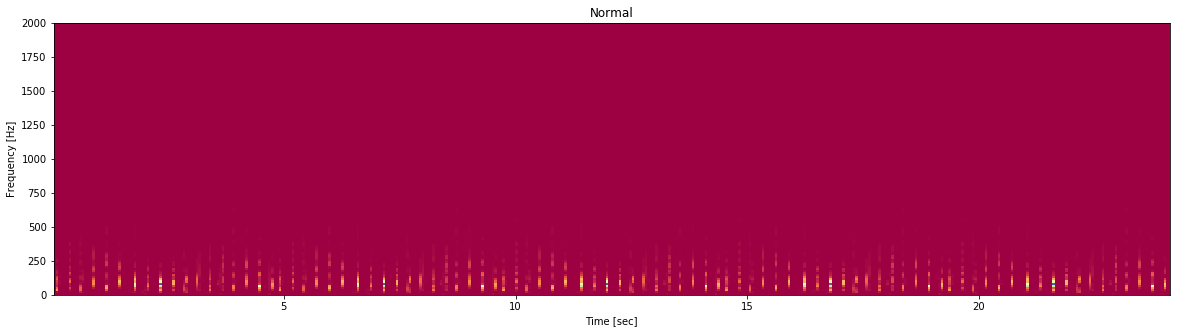

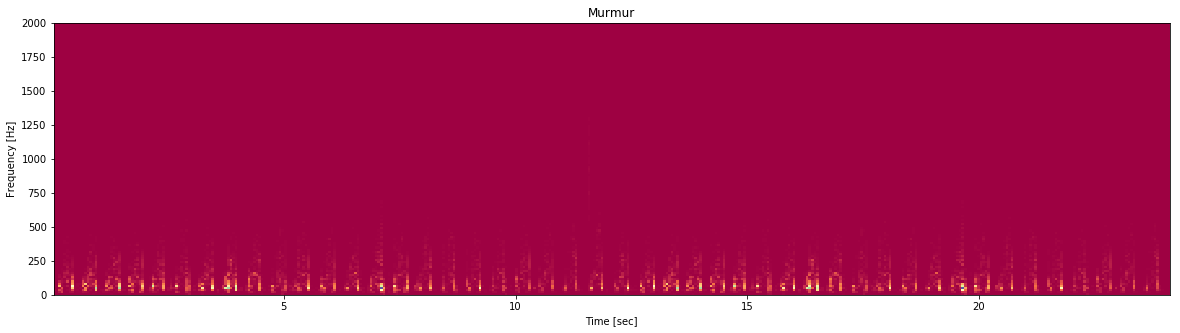

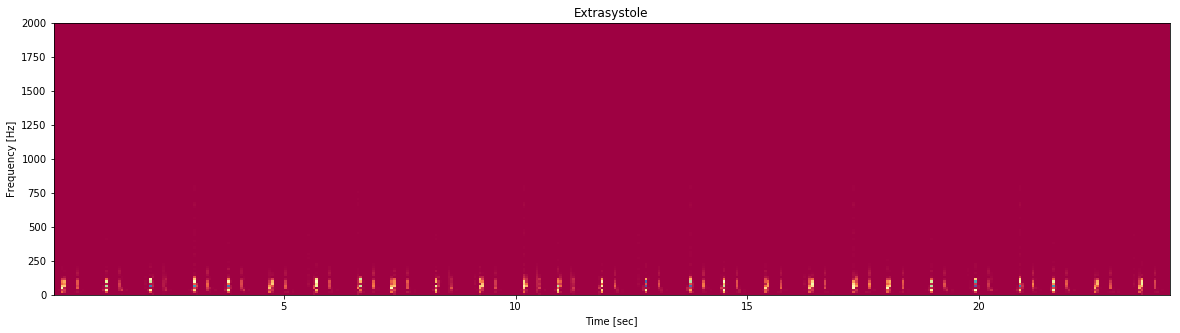

In [7]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_murmur, t_murmur, Sxx_murmur = spectrogram(murmur['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('Murmur')
plt.pcolormesh(t_murmur, f_murmur, Sxx_murmur, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [20]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [21]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, test_size=0.20)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (186, 96640), x_test: (47, 96640)


## Create a model

I think a Convolutional Neural Network may work best here, but let's try some simpler models first.

### 1. An SVM

In [22]:
clf = SVC()
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Accuracy 0.553


### 2. A Multi-Layer Perceptron Model

In [24]:
# Let's try using many hidden layers (perhaps more than 3)
clf = MLPClassifier(hidden_layer_sizes=(1024,512,256,128,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print("Accuracy %.3f" % accuracy_score(y_test, predictions))

Iteration 1, loss = 18.81769252
Iteration 2, loss = 12.13297953
Iteration 3, loss = 10.15211743
Iteration 4, loss = 0.74374897
Iteration 5, loss = 0.37241211
Iteration 6, loss = 2.35317930
Iteration 7, loss = 0.24871390
Iteration 8, loss = 0.24876054
Iteration 9, loss = 0.00121568
Iteration 10, loss = 0.00125860
Iteration 11, loss = 0.00129932
Iteration 12, loss = 0.00133775
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Accuracy 0.340


Surely we can do much better than that! Let's try a much more complex model architecture.

### 2. A Convolutional Neural Network (CNN) Model using tf.keras

In [25]:
# Convert data to the format tf.keras expects
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(186, 96640, 1)

#### The CNN model architecture

In [26]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:]))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.7))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [28]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=30,
                 validation_data=(x_test, y_test_hot))

y_train_class_names: ['normal' 'murmur' 'extrastole']
y_test_class_names: ['normal' 'murmur' 'extrastole']
Train on 186 samples, validate on 47 samples
Epoch 1/30
186/186 [==============================] - 6s 32ms/step - loss: 1.1075 - acc: 0.4355 - val_loss: 1.7676 - val_acc: 0.1915
Epoch 2/30
186/186 [==============================] - 4s 22ms/step - loss: 0.9740 - acc: 0.5484 - val_loss: 1.6389 - val_acc: 0.1915
Epoch 3/30
186/186 [==============================] - 4s 22ms/step - loss: 0.8859 - acc: 0.6129 - val_loss: 1.4136 - val_acc: 0.2128
Epoch 4/30
186/186 [==============================] - 4s 22ms/step - loss: 0.9134 - acc: 0.5699 - val_loss: 1.2186 - val_acc: 0.3191
Epoch 5/30
186/186 [==============================] - 4s 22ms/step - loss: 0.8406 - acc: 0.6129 - val_loss: 1.1689 - val_acc: 0.3191
Epoch 6/30
186/186 [==============================] - 4s 23ms/step - loss: 0.7903 - acc: 0.6989 - val_loss: 1.1494 - val_acc: 0.3404
Epoch 7/30
186/186 [==============================

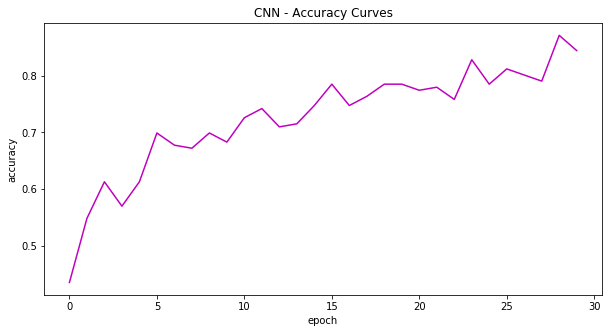

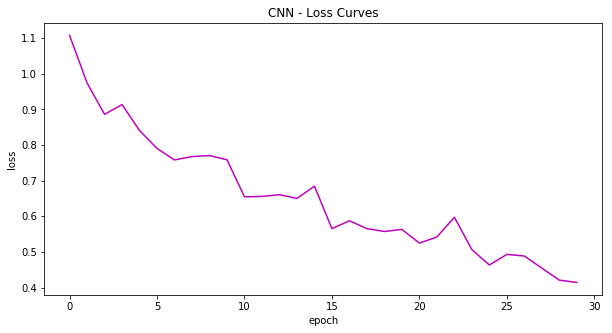

In [29]:
accuracy = hist.history['acc']
loss = hist.history['loss']

plt.figure(1, figsize=(10, 5))
plt.title('CNN - Accuracy Curves')
plt.plot(accuracy, c='m')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.figure(2, figsize=(10, 5))
plt.title('CNN - Loss Curves')
plt.plot(loss, c='m')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [39]:
import time
start = time.time()*1000
model.predict(x_test)
end = time.time()*1000
total = end - start
print("Total prediction time (milliseconds) for %d samples: %f" % (len(x_test), total))
print("Average prediction time for one example: %f" % (total/len(x_test)))

Total prediction time (milliseconds) for 47 samples: 396.935791
Average prediction time for one example: 8.445442


In [42]:
# Save the train model
tf.keras.models.save_model(
    model,
    filepath='/tmp/heartbeat/saved_model',
    overwrite=True,
    include_optimizer=True
)